In [426]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import random
random.seed(108448)
from scipy.stats import poisson

#%pip install gurobipy
import gurobipy as gp
from gurobipy import GRB

In [427]:
#Define the number of elememts in each set I, J, K
i_num = 20
k_num = 1
j_num = 100 #Without I and K, so real j_num_real = j_num + i_num + k_num

#Define empty data frames
I = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longtitude'])
J = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longtitude'])
K = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longtitude'])


In [428]:
#Define sets of I, J, K, where J contains I and K

for i in range(i_num):
    I.loc[i, 'Point number'] = 'i'+ str(i)
    I.loc[i, 'Latitude'] = round(random.uniform(0, 100), 4)
    I.loc[i, 'Longtitude'] = round(random.uniform(0, 100), 4)

I.index = I['Point number']
    
    
for k in range(k_num):
    K.loc[k, 'Point number'] = 'k'+ str(k)
    K.loc[k, 'Latitude'] = round(random.uniform(0, 100), 4)
    K.loc[k, 'Longtitude'] = round(random.uniform(0, 100), 4)

K.index = K['Point number']


for j in range(j_num):
    J.loc[j, 'Point number'] = 'j'+ str(j)
    J.loc[j, 'Latitude'] = round(random.uniform(0, 100), 4)
    J.loc[j, 'Longtitude'] = round(random.uniform(0, 100), 4)

J.index = J['Point number'] 
J = pd.concat([J, K], axis = 0) #Include K to J
I.index

Index(['i0', 'i1', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7', 'i8', 'i9', 'i10',
       'i11', 'i12', 'i13', 'i14', 'i15', 'i16', 'i17', 'i18', 'i19'],
      dtype='object', name='Point number')

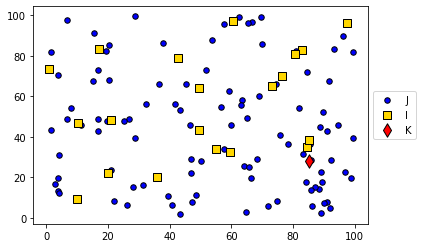

In [429]:
plt.scatter(J['Latitude'], J['Longtitude'], color = 'blue', edgecolors = 'black',
            marker = 'o', s = 30, label = 'J')
plt.scatter(I['Latitude'], I['Longtitude'], color = 'gold', edgecolors = 'black',
            marker = 's', s = 50, label = 'I')
plt.scatter(K['Latitude'], K['Longtitude'], color = 'red', edgecolors = 'black',
            marker = 'd', s = 90, label = 'K')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [430]:
#Define constants

B = 100
S = 10
alpha = 10
beta = 400
q_j = {j: 50 for j in J.index}
mu = {i : int(round(random.uniform(0, 12), 0)) for i in I.index}
mu

{'i0': 10,
 'i1': 5,
 'i2': 5,
 'i3': 7,
 'i4': 5,
 'i5': 7,
 'i6': 2,
 'i7': 1,
 'i8': 3,
 'i9': 12,
 'i10': 7,
 'i11': 2,
 'i12': 2,
 'i13': 5,
 'i14': 3,
 'i15': 8,
 'i16': 10,
 'i17': 6,
 'i18': 2,
 'i19': 6}

Deterministic model

In [431]:
theta_det = {}
for n in I.index:
    theta_det[n] = list(poisson.rvs(mu[n], size = 1))[0]
theta_det

{'i0': 8,
 'i1': 10,
 'i2': 3,
 'i3': 8,
 'i4': 5,
 'i5': 8,
 'i6': 1,
 'i7': 2,
 'i8': 3,
 'i9': 14,
 'i10': 6,
 'i11': 4,
 'i12': 3,
 'i13': 5,
 'i14': 5,
 'i15': 12,
 'i16': 5,
 'i17': 6,
 'i18': 4,
 'i19': 7}

In [432]:
#Define distance matrices

def distance(point1, PointsSet1, point2, PointsSet2):
    c1 = np.array((PointsSet1.loc[point1, 'Latitude'], PointsSet1.loc[point1, 'Longtitude']))
    c2 = np.array((PointsSet2.loc[point2, 'Latitude'], PointsSet2.loc[point2, 'Longtitude']))
    return np.linalg.norm(c1-c2)

dist_JI = {(c1, c2): distance(c1, J, c2, I)for c1, c2 in itertools.product(J.index, I.index)}
dist_IK = {(c1, c2): distance(c1, I, c2, K)for c1, c2 in itertools.product(I.index, K.index)}
dist_KJ = {(c1, c2): distance(c1, K, c2, J)for c1, c2 in itertools.product(K.index, J.index)}
 
dist_KJ


{('k0', 'j0'): 0.7038110897108715,
 ('k0', 'j1'): 61.63185199391626,
 ('k0', 'j2'): 24.640246181602976,
 ('k0', 'j3'): 61.32478256700141,
 ('k0', 'j4'): 81.02850557180479,
 ('k0', 'j5'): 22.68038149238236,
 ('k0', 'j6'): 21.246853083221527,
 ('k0', 'j7'): 20.553040081214252,
 ('k0', 'j8'): 22.49928410261091,
 ('k0', 'j9'): 64.20516841890534,
 ('k0', 'j10'): 11.54995390337122,
 ('k0', 'j11'): 40.42932303613307,
 ('k0', 'j12'): 10.662457088776483,
 ('k0', 'j13'): 35.80069974246313,
 ('k0', 'j14'): 36.65662633590276,
 ('k0', 'j15'): 49.01167981216314,
 ('k0', 'j16'): 57.46364507208013,
 ('k0', 'j17'): 74.48550248054987,
 ('k0', 'j18'): 15.552529815113685,
 ('k0', 'j19'): 38.588013090595894,
 ('k0', 'j20'): 21.152521540941635,
 ('k0', 'j21'): 82.83783882242463,
 ('k0', 'j22'): 72.37686257099018,
 ('k0', 'j23'): 70.81371710692781,
 ('k0', 'j24'): 104.76623322927097,
 ('k0', 'j25'): 24.54820101371993,
 ('k0', 'j26'): 69.90855526300054,
 ('k0', 'j27'): 16.69475911925655,
 ('k0', 'j28'): 3.727

In [433]:
#Define set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= 0.5*B:
        L.append((k, j))
        
L

[('k0', 'j0'),
 ('k0', 'j2'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j25'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j37'),
 ('k0', 'j39'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j47'),
 ('k0', 'j50'),
 ('k0', 'j54'),
 ('k0', 'j59'),
 ('k0', 'j62'),
 ('k0', 'j63'),
 ('k0', 'j66'),
 ('k0', 'j69'),
 ('k0', 'j71'),
 ('k0', 'j72'),
 ('k0', 'j74'),
 ('k0', 'j75'),
 ('k0', 'j76'),
 ('k0', 'j77'),
 ('k0', 'j78'),
 ('k0', 'j80'),
 ('k0', 'j86'),
 ('k0', 'j90'),
 ('k0', 'j92'),
 ('k0', 'j93'),
 ('k0', 'j94'),
 ('k0', 'j95'),
 ('k0', 'j96'),
 ('k0', 'j97'),
 ('k0', 'j98'),
 ('k0', 'j99'),
 ('k0', 'k0')]

In [434]:
#Define sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []

M_kj_interim = {key : val for key, val in M_kj.items() if val != []}  

KJ_feas = list(M_kj_interim.keys())
KJ_feas


[('k0', 'j0'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j18'),
 ('k0', 'j20'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j34'),
 ('k0', 'j37'),
 ('k0', 'j47'),
 ('k0', 'j77'),
 ('k0', 'j92'),
 ('k0', 'j95'),
 ('k0', 'j99'),
 ('k0', 'k0')]

In [435]:
#Define sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []
    
N_i_interim = {key : val for key, val in N_i.items() if val != []}   
 
I_feas = list(N_i_interim.keys())
I_feas

['i0', 'i1', 'i3', 'i4', 'i5', 'i11', 'i15']

In [436]:
model_det = gp.Model('Location-allocation problem 1')

In [437]:
x_ikj = model_det.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_det.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')

In [438]:
model_det.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) >= theta_det[i] for i in I_feas), name = 'c2')
model_det.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj[(k, j)]) <= q_j[j] * y_j[j] for (k, j) in KJ_feas), name = 'c4')
model_det.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] <= B
                  for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c5')
model_det.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c6')

{}

In [439]:
model_det.setObjective(alpha * gp.quicksum(x_ikj) + beta * gp.quicksum(y_j), GRB.MINIMIZE)

In [440]:
model_det.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 25 rows, 1181 columns and 68 nonzeros
Model fingerprint: 0x72066d17
Variable types: 0 continuous, 1181 integer (101 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [1e+01, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 1e+01]
Found heuristic solution: objective 2950.0000000
Presolve removed 15 rows and 1160 columns
Presolve time: 0.00s
Presolved: 10 rows, 21 columns, 34 nonzeros
Found heuristic solution: objective 2550.0000000
Variable types: 0 continuous, 21 integer (8 binary)

Root relaxation: objective 2.150000e+03, 12 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumb

In [441]:
nSolutions = model_det.SolCount
print('Number of solutions found: ' + str(nSolutions))
#for e in range(nSolutions):
for iter2 in range(1):
        model_det.setParam(GRB.Param.SolutionNumber, iter2)
        print('%g ' % model_det.PoolObjVal, end='\n')
        for v in model_det.getVars():
             if v.xn > 0:
                   print ('%s %g' % (v.varName, v.Xn))
        print("\n")
print("\n")

Number of solutions found: 3
2150 
x_ikj[i0,k0,j0] 8
x_ikj[i1,k0,j92] 10
x_ikj[i3,k0,j99] 8
x_ikj[i4,k0,j0] 5
x_ikj[i5,k0,j99] 8
x_ikj[i11,k0,j92] 4
x_ikj[i15,k0,j29] 12
y_j[j0] 1
y_j[j29] 1
y_j[j92] 1
y_j[j99] 1






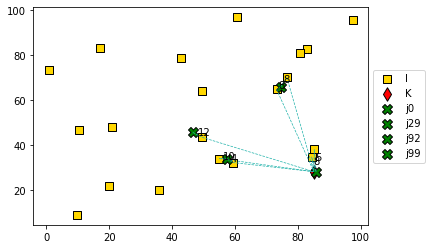

In [442]:
def SolutionGraph(I, K, J, model):
    
    # plt.scatter(J['Latitude'], J['Longtitude'], color = 'blue', edgecolors = 'black',
    #             marker = 'o', s = 30, label = 'J')
    plt.scatter(I['Latitude'], I['Longtitude'], color = 'gold', edgecolors = 'black',
                marker = 's', s = 50, label = 'I')
    plt.scatter(K['Latitude'], K['Longtitude'], color = 'red', edgecolors = 'black',
                marker = 'd', s = 90, label = 'K')


    for v in model.getVars():
        if v.xn > 0:
            if v.varName.startswith('x_ikj'):
                indices_x = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                plt.plot((J.loc[indices_x[2], 'Latitude'], I.loc[indices_x[0], 'Latitude']),
                        (J.loc[indices_x[2], 'Longtitude'], I.loc[indices_x[0], 'Longtitude']),
                        color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                plt.plot((I.loc[indices_x[0], 'Latitude'], K.loc[indices_x[1], 'Latitude']),
                        (I.loc[indices_x[0], 'Longtitude'], K.loc[indices_x[1], 'Longtitude']),
                        color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                plt.annotate(str(int(v.xn)), xy = ((J.loc[indices_x[2], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2,
                                                (J.loc[indices_x[2], 'Longtitude'] + I.loc[indices_x[0], 'Longtitude'])/2))
            else:
                index_y = v.varName[4:-1]
                plt.scatter(J.loc[index_y, 'Latitude'], J.loc[index_y, 'Longtitude'], color = 'green',
                            edgecolors = 'black', s = 100, marker = 'X', label = index_y)
        
            

    plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
    

SolutionGraph(I, K, J, model_det)

Probabilistic model

In [445]:
theta_ran_i = {}
for n in list(I.index):
    theta_ran_i[n] = poisson(mu[n])

p = 0.97

l_i = {}
for i in theta_ran_i.keys():
    l_i[i] = theta_ran_i[i].ppf(p)

l_i

{'i0': 16.0,
 'i1': 10.0,
 'i2': 10.0,
 'i3': 12.0,
 'i4': 10.0,
 'i5': 12.0,
 'i6': 5.0,
 'i7': 3.0,
 'i8': 7.0,
 'i9': 19.0,
 'i10': 12.0,
 'i11': 5.0,
 'i12': 5.0,
 'i13': 10.0,
 'i14': 7.0,
 'i15': 14.0,
 'i16': 16.0,
 'i17': 11.0,
 'i18': 5.0,
 'i19': 11.0}